### Imports

In [61]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

### Data ingest

In [6]:
data_client = 'client.csv'
data_countyidm = 'county_id_to_name_map.json'
data_elec = 'electricity_prices.csv'
data_fw = 'forecast_weather.csv'
data_gp = 'gas_prices.csv'
data_hw = 'historical_weather.csv'
data_t = 'train.csv'
data_wtc = 'weather_station_to_county_mapping.csv'

# data_ = '

In [7]:
df_t = pd.read_csv('../data_enefit_kggl/' + data_t)

df_cl = pd.read_csv('../data_enefit_kggl/' + data_client)
#df_cn = pd.read_json('../data_enefit_kggl/' + data_countyidm) # json
df_el = pd.read_csv('../data_enefit_kggl/' + data_elec)
df_fw = pd.read_csv('../data_enefit_kggl/' + data_fw)
df_gp = pd.read_csv('../data_enefit_kggl/' + data_gp)
df_hw = pd.read_csv('../data_enefit_kggl/' + data_hw)

df_wtc = pd.read_csv('../data_enefit_kggl/' + data_wtc)

print(df_t.shape, df_cl.shape, df_el.shape, df_fw.shape, 
     df_gp.shape, df_hw.shape, df_wtc.shape)

(2018352, 9) (41919, 7) (15286, 4) (3424512, 18) (637, 5) (1710800, 18) (112, 4)


### Feature engineering and feature aggregation

### Create X_1

In [8]:
# Example of creating decent X from provided csv docs:
# https://www.kaggle.com/code/anubhavtyagi1212/eenefit-predict-energy-behaviour

In [9]:
df = []
df = df_t.copy()
print(df.shape)

(2018352, 9)


### Datetime features

In [10]:
df['datetime2'] = df['datetime'].astype('datetime64[ns]')
df['year'] = df['datetime2'].astype('datetime64[ns]').dt.year
df['month'] = df['datetime2'].astype('datetime64[ns]').dt.month
df['day'] = df['datetime2'].astype('datetime64[ns]').dt.day
df['day_of_week'] = df['datetime2'].astype('datetime64[ns]').dt.dayofweek
df['day_of_year'] = df['datetime2'].astype('datetime64[ns]').dt.dayofyear
df['hour_of_day'] = df['datetime2'].astype('datetime64[ns]').dt.hour
df['date'] = df['datetime2'].dt.date
print(df.shape)

(2018352, 17)


In [11]:
df[['datetime', 'datetime2', 'year', 'month',
    'day_of_week', 'day_of_year', 'hour_of_day', 'date'
   ]].head(3)

,datetime,datetime2,year,month,day_of_week,day_of_year,hour_of_day,date
0,2021-09-01 00:00:00,2021-09-01,2021,9,2,244,0,2021-09-01
1,2021-09-01 00:00:00,2021-09-01,2021,9,2,244,0,2021-09-01
2,2021-09-01 00:00:00,2021-09-01,2021,9,2,244,0,2021-09-01


### Column drop 

(study why this)

In [12]:
print(df.shape)
df = df.drop(['county','is_business','is_consumption','product_type'],axis=1)
print(df.shape)

(2018352, 17)
(2018352, 13)


### Gas price features

In [13]:
df_gp.columns

Index(['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh',
       'origin_date', 'data_block_id'],
      dtype='object')

In [14]:
df_gp['forecast_date2'] = df_gp['forecast_date'].astype('datetime64[ns]')

In [15]:
df['lowest_price_per_mwh'] = df.reset_index()['datetime2'].map(df_gp.set_index(['forecast_date2'])['lowest_price_per_mwh'])
df['highest_price_per_mwh'] = df.reset_index()['datetime2'].map(df_gp.set_index(['forecast_date2'])['highest_price_per_mwh'])

In [16]:
print(df.columns)
df[['lowest_price_per_mwh', 'highest_price_per_mwh']].head(3)

Index(['target', 'datetime', 'data_block_id', 'row_id', 'prediction_unit_id',
       'datetime2', 'year', 'month', 'day', 'day_of_week', 'day_of_year',
       'hour_of_day', 'date', 'lowest_price_per_mwh', 'highest_price_per_mwh'],
      dtype='object')


,lowest_price_per_mwh,highest_price_per_mwh
0,45.23,46.32
1,45.23,46.32
2,45.23,46.32


### Electricity price features

In [24]:
df_el['forecast_date2'] = df_el['forecast_date'].astype('datetime64[ns]')

In [25]:
print(df.shape)
df['euros_per_mwh'] = df.reset_index()['datetime2'].map(df_el.set_index(['forecast_date2'])['euros_per_mwh'])
print(df.shape)
print(df.columns)

(2018352, 16)
(2018352, 16)
Index(['target', 'datetime', 'data_block_id', 'row_id', 'prediction_unit_id',
       'datetime2', 'year', 'month', 'day', 'day_of_week', 'day_of_year',
       'hour_of_day', 'date', 'lowest_price_per_mwh', 'highest_price_per_mwh',
       'euros_per_mwh'],
      dtype='object')


### Client features

In [26]:
df_cl['date2'] = df_cl['date'].astype('datetime64[ns]')

In [27]:
df['installed_capacity'] = df.reset_index()['datetime2'].map(df_cl.drop_duplicates('date2').set_index(['date2'])['installed_capacity'])

### Weather history features

In [28]:
df_hw['datetime2'] = df_hw['datetime'].astype('datetime64[ns]')

In [29]:
df_hw[['datetime', 'datetime2']].head(3)

,datetime,datetime2
0,2021-09-01 00:00:00,2021-09-01
1,2021-09-01 00:00:00,2021-09-01
2,2021-09-01 00:00:00,2021-09-01


In [30]:
print(df.shape)
df = df.merge(df_hw.drop_duplicates('datetime2'), on='datetime2', how='left')
print(df.shape)

(2018352, 17)
(2018352, 35)


In [31]:
df.head(3)

,target,datetime_x,data_block_id_x,row_id,prediction_unit_id,datetime2,year,month,day,day_of_week,...,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id_y
0,0.713,2021-09-01 00:00:00,0,0,0,2021-09-01,2021,9,1,2,...,0.0,0.0,6.694444,3.0,0.0,0.0,0.0,57.6,21.7,1.0
1,96.590,2021-09-01 00:00:00,0,1,0,2021-09-01,2021,9,1,2,...,0.0,0.0,6.694444,3.0,0.0,0.0,0.0,57.6,21.7,1.0
2,0.000,2021-09-01 00:00:00,0,2,1,2021-09-01,2021,9,1,2,...,0.0,0.0,6.694444,3.0,0.0,0.0,0.0,57.6,21.7,1.0


##### There are more operations on test data, for 'prediction_datetime' , etc. Revisit this later, see https://www.kaggle.com/code/anubhavtyagi1212/eenefit-predict-energy-behaviour

##### Possibly the "predicted weather" data is just for test data prediction, not seeing it used in what have yet .  .  .  look into it later, this plenty to start in on . . . and reunway 4 weeks and 2 week vaca and then jan2024 final drive to get into it . . . 

### Assess enhanced data

In [32]:
print(df.shape)
print(df.columns)
display(df.head(4))
display(df.tail(4))

(2018352, 35)
Index(['target', 'datetime_x', 'data_block_id_x', 'row_id',
       'prediction_unit_id', 'datetime2', 'year', 'month', 'day',
       'day_of_week', 'day_of_year', 'hour_of_day', 'date',
       'lowest_price_per_mwh', 'highest_price_per_mwh', 'euros_per_mwh',
       'installed_capacity', 'datetime_y', 'temperature', 'dewpoint', 'rain',
       'snowfall', 'surface_pressure', 'cloudcover_total', 'cloudcover_low',
       'cloudcover_mid', 'cloudcover_high', 'windspeed_10m',
       'winddirection_10m', 'shortwave_radiation', 'direct_solar_radiation',
       'diffuse_radiation', 'latitude', 'longitude', 'data_block_id_y'],
      dtype='object')


,target,datetime_x,data_block_id_x,row_id,prediction_unit_id,datetime2,year,month,day,day_of_week,...,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id_y
0,0.713,2021-09-01 00:00:00,0,0,0,2021-09-01,2021,9,1,2,...,0.0,0.0,6.694444,3.0,0.0,0.0,0.0,57.6,21.7,1.0
1,96.590,2021-09-01 00:00:00,0,1,0,2021-09-01,2021,9,1,2,...,0.0,0.0,6.694444,3.0,0.0,0.0,0.0,57.6,21.7,1.0
2,0.000,2021-09-01 00:00:00,0,2,1,2021-09-01,2021,9,1,2,...,0.0,0.0,6.694444,3.0,0.0,0.0,0.0,57.6,21.7,1.0
3,17.314,2021-09-01 00:00:00,0,3,1,2021-09-01,2021,9,1,2,...,0.0,0.0,6.694444,3.0,0.0,0.0,0.0,57.6,21.7,1.0


,target,datetime_x,data_block_id_x,row_id,prediction_unit_id,datetime2,year,month,day,day_of_week,...,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id_y
2018348,0.000,2023-05-31 23:00:00,637,2018348,59,2023-05-31 23:00:00,2023,5,31,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018349,28.404,2023-05-31 23:00:00,637,2018349,59,2023-05-31 23:00:00,2023,5,31,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018350,0.000,2023-05-31 23:00:00,637,2018350,60,2023-05-31 23:00:00,2023,5,31,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018351,196.240,2023-05-31 23:00:00,637,2018351,60,2023-05-31 23:00:00,2023,5,31,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# df2['datetime'] # lost in a merge operation, now 'datetime_x'

### Drop cols-2

In [ ]:
df.columns

In [44]:
# original set to drop from https://www.kaggle.com/code/anubhavtyagi1212/eenefit-predict-energy-behaviour: 
# ['datetime', 'data_block_id_x', 'row_id', 'prediction_unit_id','date','latitude', 'longitude', 'data_block_id_y']

df2 = df.copy()

df2['datetime'] = df['datetime_x']

df2 = df2.drop(['datetime_x','data_block_id_x', 'row_id', 
              'prediction_unit_id','datetime2', 'datetime_y',
               'date','latitude', 
              'longitude', 'data_block_id_y'
             ], axis=1) # # df['datetime'] # lost in a merge operation, now 'datetime_x'

In [45]:
df2['datetime'].head(3)

0    2021-09-01 00:00:00
1    2021-09-01 00:00:00
2    2021-09-01 00:00:00
Name: datetime, dtype: object

In [46]:
print(df2.columns)

Index(['target', 'year', 'month', 'day', 'day_of_week', 'day_of_year',
       'hour_of_day', 'lowest_price_per_mwh', 'highest_price_per_mwh',
       'euros_per_mwh', 'installed_capacity', 'temperature', 'dewpoint',
       'rain', 'snowfall', 'surface_pressure', 'cloudcover_total',
       'cloudcover_low', 'cloudcover_mid', 'cloudcover_high', 'windspeed_10m',
       'winddirection_10m', 'shortwave_radiation', 'direct_solar_radiation',
       'diffuse_radiation', 'datetime'],
      dtype='object')


In [ ]:
print(df2.columns)
display(df2.head(4))
display(df2.tail(4))

In [63]:
df = df2.copy()

In [64]:
# remove nan, at least in y (cannot split if y has NaN)
print(df.shape)
df = df.dropna()
print(df.shape)

(2018352, 26)
(83838, 26)


In [65]:
# Reduce data size:


print(df.shape)
#df = df.sample(frac=0.05)
df = df.reset_index(drop=True)
print(df.shape)

(83838, 26)
(83838, 26)


In [66]:
df_y = df[['target']]
df_X = df.drop(['target', 'datetime'], axis=1)
print(df.shape, df_X.shape, df_y.shape)

(83838, 26) (83838, 24) (83838, 1)


In [67]:
#df.to_csv('data_enefit_prep1_25nov2023a.csv', index=False)

### ML-1

In [68]:
print(df_X.columns)
display(df_X.head(3))
display(df_X.tail(10))
display(df_y.head(3))
display(df_y.tail(3))

Index(['year', 'month', 'day', 'day_of_week', 'day_of_year', 'hour_of_day',
       'lowest_price_per_mwh', 'highest_price_per_mwh', 'euros_per_mwh',
       'installed_capacity', 'temperature', 'dewpoint', 'rain', 'snowfall',
       'surface_pressure', 'cloudcover_total', 'cloudcover_low',
       'cloudcover_mid', 'cloudcover_high', 'windspeed_10m',
       'winddirection_10m', 'shortwave_radiation', 'direct_solar_radiation',
       'diffuse_radiation'],
      dtype='object')


,year,month,day,day_of_week,day_of_year,hour_of_day,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,installed_capacity,...,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation
0,2021,9,1,2,244,0,45.23,46.32,92.51,952.89,...,1015.8,4.0,4.0,0.0,0.0,6.694444,3.0,0.0,0.0,0.0
1,2021,9,1,2,244,0,45.23,46.32,92.51,952.89,...,1015.8,4.0,4.0,0.0,0.0,6.694444,3.0,0.0,0.0,0.0
2,2021,9,1,2,244,0,45.23,46.32,92.51,952.89,...,1015.8,4.0,4.0,0.0,0.0,6.694444,3.0,0.0,0.0,0.0


,year,month,day,day_of_week,day_of_year,hour_of_day,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,installed_capacity,...,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation
83828,2023,5,29,0,149,0,28.16,36.98,12.38,4964.215,...,1017.7,6.0,0.0,10.0,0.0,4.75,219.0,0.0,0.0,0.0
83829,2023,5,29,0,149,0,28.16,36.98,12.38,4964.215,...,1017.7,6.0,0.0,10.0,0.0,4.75,219.0,0.0,0.0,0.0
83830,2023,5,29,0,149,0,28.16,36.98,12.38,4964.215,...,1017.7,6.0,0.0,10.0,0.0,4.75,219.0,0.0,0.0,0.0
83831,2023,5,29,0,149,0,28.16,36.98,12.38,4964.215,...,1017.7,6.0,0.0,10.0,0.0,4.75,219.0,0.0,0.0,0.0
83832,2023,5,29,0,149,0,28.16,36.98,12.38,4964.215,...,1017.7,6.0,0.0,10.0,0.0,4.75,219.0,0.0,0.0,0.0
83833,2023,5,29,0,149,0,28.16,36.98,12.38,4964.215,...,1017.7,6.0,0.0,10.0,0.0,4.75,219.0,0.0,0.0,0.0
83834,2023,5,29,0,149,0,28.16,36.98,12.38,4964.215,...,1017.7,6.0,0.0,10.0,0.0,4.75,219.0,0.0,0.0,0.0
83835,2023,5,29,0,149,0,28.16,36.98,12.38,4964.215,...,1017.7,6.0,0.0,10.0,0.0,4.75,219.0,0.0,0.0,0.0
83836,2023,5,29,0,149,0,28.16,36.98,12.38,4964.215,...,1017.7,6.0,0.0,10.0,0.0,4.75,219.0,0.0,0.0,0.0
83837,2023,5,29,0,149,0,28.16,36.98,12.38,4964.215,...,1017.7,6.0,0.0,10.0,0.0,4.75,219.0,0.0,0.0,0.0


,target
0,0.713
1,96.590
2,0.000


,target
83835,33.713
83836,0.000
83837,153.666


In [70]:
test_size = 0.3

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, 
                                                    test_size=test_size, 
                                                    )#, stratify=y

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(58686, 24) (58686, 1) (25152, 24) (25152, 1)


In [72]:
import xgboost as xg 

In [73]:
# Instantiation 
xgb_r = xg.XGBRegressor() 

# objective ='reg:linear', n_estimators = 10, seed = 123

In [75]:
# Fitting the model 
xgb_r.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [76]:
# Predict the model 
y_pred = xgb_r.predict(X_test) 

In [78]:
y_pred[0:10]

array([163.02126, 232.97183, 132.50424, 182.1399 , 186.36836, 162.47014,
       157.46178, 218.88347, 146.81073, 175.04994], dtype=float32)

In [79]:
from sklearn.metrics import mean_absolute_error

In [80]:
mean_absolute_error(y_test, y_pred)

297.62823402505734

### Results, 11/26/2023a:

    My MAE: 297.62823402505734
    Kggl LB: Top_50: 63 to 70  (lower is better). 
             579 (worst score on LB:): 480  (but most better than 100 . . . )
             (note: this is a different test set, etc)

In [86]:
y_pred

array([163.02126, 232.97183, 132.50424, ..., 194.64897, 172.63458,
       174.51456], dtype=float32)

In [84]:
print(y_test.shape, y_pred.shape)

(25152, 1) (25152,)


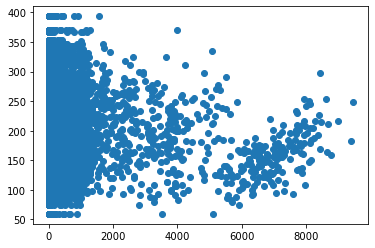

In [87]:
plt.figure()
plt.plot(y_test.values, y_pred, 'o')

(don't know what the interpretation of this should be . . . )

In [91]:
print(y_pred.shape)

(25152,)


In [99]:
df_result1 = pd.DataFrame({'y_test': y_test.values.tolist(), 
                           'y_pred': y_pred
                           })

In [100]:
df_result1

,y_test,y_pred
0,[37.12],163.021255
1,[0.0],232.971832
2,[45.535],132.504242
3,[3.371],182.139893
4,[0.057],186.368362
...,...,...
25147,[102.378],108.131821
25148,[0.0],158.362503
25149,[0.0],194.648972
25150,[139.717],172.634583


hmmm . . . badly in many cases . . . look into later . . . 

### Interesting Reads

* Example of creating decent X from provided csv docs:
 https://www.kaggle.com/code/anubhavtyagi1212/eenefit-predict-energy-behaviour